# 04 Passende Satellitenobjekte zu den HACI-Detektionen

Um verlässliche Aussagen über die satellitenbasiereten Eigenschaften der HACI-Objekte zu machen, ist es wichtig das richtige Satellitenobjekt zuordnen zu können. Deshalb sollen in diesem Notebook verschiedene Ansätze untersucht und verglichen werden. 

## 1. Mögliche Grundlage
Für die Objektdefinition müssen die Satellitenfelder segmentiert werden. Das kann prinzipell auf einer Reihe von Feldern gemacht werden ist wahrscheinlich aber sinnvoll für:

1. IR 10,8&thinsp;&mu;m
2. HRV
3. NWC&thinsp;SAF-Wolkenmaske
4. HRV-Wolkenmaske

Prinzipiell ist von einer Segmentierung auf dem HRV-Feld oder der HRV-Wolkenmaske die beste Trennung von Objekten zu erwarten. Allerdings ist das nur für Fälle mit ausreichender Sonnenillumination möglich. Ein weiteres Problem könnten hier die höheren Texturunterschiede im HRV-Kanal sein.

## 2. Mögliche Segmentierungsansätze
Der verwendete Segmenteirungsansatz ist für das resultierende Objekt essentiell. Es gibt hierfür eine Vielzahl von möglichen Ansätzen. Ausprobiert wurden:

1. einzelner Schwellwert aus theoretischen Überlegungen
2. automatisch bestimmter Schwellwert (Otsu-Verfahren)
3. adaptiver Schwellwertansatz, mit Berechnung des Schwellwertes aus dem Feld
4. Wasserscheidtransformation
5. morphologische Rekonstruktion + Schwellwert
6. multispektrale Schwellwerte

Keiner der Ansätze bringt ein befriedigendes Ergebnis für alle möglichen HACI-Fälle, aber damit muss man wohl leben.

## 3. Beispiele

Im Folgenden werden die verschiednen Ansätze für einige Beispiel-HACI-Fälle dargestellt.

### 3.1 Einzelschellwert

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import xarray as xr

from standard_config import *
import sys
sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot

from analysis_tools import segmentation as atseg
from skimage import segmentation as spseg
import skimage.filters as filters

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap()

from plotting_tools.colormaps import radar_cmap as rc


from IPython.display import display, Image
import ipywidgets as widgets
from ipywidgets import HBox, VBox

from scipy import ndimage as ndi
from skimage.morphology import h_minima
import glob

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
haci_track_data_path = "{}/HACI_track_data/".format(local_data_path)
haci_bbox_data_path = "{}/HACI_bbox_data/".format(local_data_path)

In [3]:
def read_nc_file(filename):
    data = {}
    
    with xr.open_dataset(filename) as f:
        for d in f.data_vars:
            data[d] = f[d].data.copy()
        for d in f.coords:
            data[d] = f.coords[d].data.copy()
    return data

In [4]:
wanted_date = "20130618"

In [5]:
track_files = glob.glob("{}track_{}_*.nc".format(haci_track_data_path,wanted_date))

In [6]:
track_files

['/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_2831.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_3029.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_2992.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_759.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_3328.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_2770.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_2655.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_2336.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_2262.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_3207.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_2687.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_3326.nc']

In [7]:
track_data = {}
track_ids = []

In [8]:
for tf in track_files:
    tid = int(tf.split("/")[-1].split(".")[0].split("_")[-1])
    track_ids.append(tid)
    track_data[tid] = read_nc_file(tf)

In [10]:
track_ids.sort()

In [21]:
track_ids

[759, 2262, 2336, 2655, 2687, 2770, 2831, 2992, 3029, 3207, 3326, 3328]

In [27]:
@widgets.interact(tidx=(0, 12),
                  tid=track_ids)
def f(tidx=0,tid=759):
    try:
        fig,ax = plt.subplots(1,2,figsize=(12,6))
        ax[0].pcolormesh(track_data[tid]['slon'],
                         track_data[tid]['slat'],
                         track_data[tid]['ir108'][tidx],
                         vmin=210,vmax=300,cmap=emap)
        ax[0].contourf(track_data[tid]['rlon'],
                       track_data[tid]['rlat'],
                       np.ma.masked_greater_equal(np.ma.masked_less(track_data[tid]['rx'][tidx],5),92.5),
                       vmin=5,vmax=70,cmap=rc(),alpha=0.6)
        ax[1].pcolormesh(track_data[tid]['hlon'],
                         track_data[tid]['hlat'],
                         track_data[tid]['hrv'][tidx],
                         vmin=0,vmax=1,cmap='gray')
        ax[1].contourf(track_data[tid]['rlon'],
                       track_data[tid]['rlat'],
                       np.ma.masked_greater_equal(np.ma.masked_less(track_data[tid]['rx'][tidx],5),92.5),
                       vmin=5,vmax=70,cmap=rc(),alpha=0.6)
        plt.suptitle("Track {}, Zeit: {}".format(tid, 
                                                 np.datetime_as_string(track_data[tid]['time'][tidx],
                                                                       timezone='UTC',unit='m')))
    except Exception as e:
        print(e)

interactive(children=(IntSlider(value=0, description='tidx', max=12), Dropdown(description='tid', options=(759…

Die einzelnen HACI-Objekte unterscheiden sich recht start, aber es sind eine reihe von relativ gut isolierten Fällen dabei. Allerdings gibt es auch Fälle, die nicht isoliert sind, sondern wo der Niederschlag relativ spät in einem MCS einsetzt.

## 3. Wolkenobjekte

Wie sich bisher gezeigt hat ist es fast unmöglich eine Objektdefinition zu finden, die für alle möglichen Fälle zuverlässig funktioniert. Deshalb soll hier untersucht werden, wann und warum eine Reihe von relativ einfachen Objektdefinitionen scheitert und wo sie gut funktionieren.

Der einfachste Ansatz ist sich eines der Satellitenbeobachtungsfelder zu nehmen und einzelene Schwellwerte zu definieren.

### 3.1 Einzelner Schwellwert aus Beobachtungen und theoretischen Überlegungen

Seitdem Satellitenbeobachtungen von Konvektion analysiert werden, sind eine Reihe von möglichen Schwellwerten vorgeschlagen worden, insbesondere für die Wolkenoberkantentemperatur im atmosphärischen Fenster. In der Literatur verwendete Werte sind:

| Autor         | kritischer Schwellwert / K      |  Anmerkung                             |
|---------------|---------------------------------|----------------------------------------|
| Maddox (1980) | 241 und 221                     | ursprünglich für die Untersuchung von MCC  in Nordamerika|
| Adler et al. (1986) | 226 | reifes Gewitter |
| Velasco & Fritsch ( 1987) | 233 und 211 |  ursprünglich für die Untersuchung von MCC in Südamerika |
| Machado & Rossow (1993) | 252 und 206 | MCS in Südamerika |
| Anderson & Arrit (1998) | 221 | MCS in Nordamerika |
| Bedka (2010) | 225 | reife Gewitter in Europa |

Die Auswahl von Maddox (1980) basiert auf der Beobachtung, dass sich konvektiver Niederschlag bei unter 241&thinsp;K zu akkumulieren beginnt und die Werte von Velasco & Fritsch (1987) sind eine Anpassung für eine andere Hellikeitstemperaturverbesserungskurve.

Theoretische Überlegungen und Satellitenbeobachtungen zeigen, dass bei einer Helligkeitstemperatur von unter 243&thinsp;K häufig stark unterkühltes Wasser vorhanden ist, was auf starke Vertikalbewegungen hindeutet (Da Silva Nato et al, 2016). Flugzeugmessungen zeigen, dass bei 233&thinsp;K nur noch Eiskristalle vorhanden sind (Rosenfeld & Woodley, 2003). Dieses wird allerdings erst später als die konektive Auslösung erreicht. Deshalb benötigen wir hier höhere Schwellwerte, um auch vernünftige Objekte in der Frühphase definieren zu können. Für passende Schwellwerte sollten wir uns unsere Beispiele ansehen.

Die Vorgehensweise ist wie folgt:

1. Wir suchen uns die lokalen Minima aller Wolken im Ausschnitt.
2. Wir erzeugen Ellipsen um die lokalen Minima, um sie verfolgen zu können.
3. Wir suchen uns das Objekt, das zum Auslösungszeitpunkt am nächsten am HACI-Objekt, also am nächsten zur Ausschnittmitte liegt.
4. Wir sehen uns die Eigenschaften der Ellipsen für diese Objekt an.

#### 1. Lokale Minima suchen

Wir suchen uns das lokale Minimum der Wolken im IR_10,8&thinsp;µm-Feld. Dazu sehen wir uns zuerst mal an, was für verschiedene Tiefen und Glättungsstärken passiert.

In [ ]:
# def get_local_h_minima(field,depth,gauss_sigma=1):
#     field_smooth = ndi.gaussian_filter(field,gauss_sigma)
    
#     # find local minima of the given depth
#     local_mins = h_minima(field_smooth,depth)
    
#     # field with labeled local minima
#     lm_labeled = ndi.label(local_mins)[0]
    
#     return lm_labeled

# def get_track_ellipses(field,ellipsis_width=5,ellipsis_height=9,elipsis_rotation=0):
#     from skimage.draw import ellipse
#     ellipses_field = np.zeros_like(field, dtype="uint8")
    
#     # check if field is labeled, if not, label it
#     if np.max(field) == 1:
#         field = ndi.label(field)[0]
    
#     for l in np.unique(field)[1:]:
#         min_loc = np.where(field == l)
    
#         rr, cc = ellipse(min_loc[0][0],
#                          min_loc[1][0],
#                          ellipsis_width, 
#                          ellipsis_height, 
#                          rotation=elipsis_rotation)
        
#         rr = np.clip(rr,0,field.shape[0]-1)
#         cc = np.clip(cc,0,field.shape[1]-1)
#         ellipses_field[rr,cc] = l
    
#     ellipses_field = ~np.ma.masked_less(ellipses_field,1).mask*1
#     return ellipses_field 

In [43]:
reload(ot)

<module 'object_tracking' from '/vols/satellite/home/lenk/utils/tracking/object_tracking.py'>

In [34]:
ot.get_labeled_local_minima??

In [32]:
def euclidian_distance(points,reference_point=(25,25)):
    distances = []
    
    for i in range(len(points[0])):
        d = np.sqrt((points[0][i] - reference_point[0])**2 + (points[1][i] - reference_point[1])**2)
        distances.append(d)
        
    return distances

In [39]:
ot.get_track_ellipses??

interactive(children=(IntSlider(value=0, description='tidx', max=12), Dropdown(description='tid', options=(759…

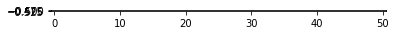

In [44]:
@widgets.interact(tidx=(0, 12),tid = track_ids,depth=(1,15),sigma=(0,25))
def f(tidx=0,tid=759,depth=10,sigma=0):
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(track_data[tid]['ir108'][tidx],
              vmin=210,vmax=300,cmap=emap)
    
    lmins = ot.get_labeled_local_minima(track_data[tid]['ir108'][tidx],depth,sigma)
    min_loc = np.where(lmins>0)
    
    lmin_ellipses = ot.get_track_ellipses(lmins)
    #minima = np.array([[min_loc[0][i],min_loc[1][i]] for i in range(len(min_loc[0]))])
    #vor = Voronoi(minima)
    
    for i in range(len(min_loc[0])):
        ax.plot(min_loc[1][i],min_loc[0][i],'mo',markersize=7,mew=2)
        #ax.plot(vor.vertices[i][1],vor.vertices[i][0],'r+')
    
    distances = euclidian_distance(min_loc,(25,25))
    ax.plot(min_loc[1][np.argmin(distances)], min_loc[0][np.argmin(distances)],'g+')

Ohne eine kleine Glättung bekommen wir manchmal mehrere eng beieinander liegende lokale Minima. Eine Glättung von &sigma;&thinsp;=&thinsp;1 behebt dieses Problem, führt allerdings dazu, dass manche sinnvollen lokalen Minima verschwinden. 

Eine Minimumtiefe von 4&thinsp;K bei einer Glättung mit &sigma;&thinsp;=&thinsp;1 scheint ein guter Anfagspunkt zu sein.

#### 2. Ellipsen
Als nächstes erzeugen wir Ellipsen mit einer Größe von 3&thinsp;px&thinsp;&times;&thinsp;6&thinsp;px.

In [10]:
lmins = get_local_h_minima(track_data[759]['ir108'][6],4,1)
min_loc = np.where(lmins>0)
distances = euclidian_distance(min_loc,(25,25))
#ax.plot(min_loc[1][np.argmin(distances)], min_loc[0][np.argmin(distances),'g+'])

In [11]:
lmin_ellipses = get_track_ellipses(lmins,ellipsis_width=3,ellipsis_height=6)

In [12]:
np.unique(min_loc)

array([ 0,  4,  5, 16, 19, 21, 22, 26, 29, 37, 45, 50])

In [13]:
np.unique(lmin_ellipses)

array([0, 1])

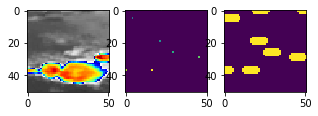

In [14]:
fig,ax = plt.subplots(1,3,figsize=(5,15))
ax[0].imshow(track_data[759]['ir108'][6],vmin=210,vmax=300,cmap=emap)
ax[1].imshow(lmins)
ax[2].imshow(lmin_ellipses)

In [9]:
def lmin_ellipses(field,depth=10,sigma=1,width=3,height=3):
    ellipses = []

    for i,f in enumerate(field):
        lmins = get_local_h_minima(f,10,1)
        lmin_ellipses = get_track_ellipses(lmins,ellipsis_width=3,ellipsis_height=3)

        ellipses.append(lmin_ellipses)
        
    return ellipses

In [50]:
reload(ot)

<module 'object_tracking' from '/vols/satellite/home/lenk/utils/tracking/object_tracking.py'>

In [51]:
t = 759
ellipsen = ot.lmin_ellipses(track_data[t]['ir108'])

In [53]:
ellipsen = ndi.label(np.array(ellipsen))[0]

interactive(children=(IntSlider(value=0, description='tidx', max=12), Dropdown(description='tid', options=(759…

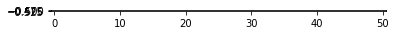

In [56]:
@widgets.interact(tidx=(0, 12),tid = track_ids,depth=(1,15),sigma=(0,25))
def f(tidx=0,tid=759,depth=10,sigma=0):
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(track_data[tid]['ir108'][tidx],
              vmin=210,vmax=300,cmap=emap)
    
    lmins = ot.get_labeled_local_minima(track_data[tid]['ir108'][tidx],depth,sigma)
    min_loc = np.where(lmins>0)
    
    lmin_ellipses = ot.get_track_ellipses(lmins,ellipsis_width=3,ellipsis_height=3)
    
    for i in range(len(min_loc[0])):
        ax.plot(min_loc[1][i],min_loc[0][i],'mo',markersize=7,mew=2)
        #ax.plot(vor.vertices[i][1],vor.vertices[i][0],'r+')
    
    distances = euclidian_distance(min_loc,(25,25))
    ax.plot(min_loc[1][np.argmin(distances)], min_loc[0][np.argmin(distances)],'g+')
    ax.imshow(np.ma.masked_less(lmin_ellipses,1),alpha=0.7,vmin=0,vmax=1,cmap='Greens')

### 3. Ellipse auswählen

Das scheint soweit ganz gut zu funktionieren. Als nächstes suchen wir uns diejenige Ellipsenreihe, die zum Auslösungszeitpunkt am nächsten am Ausschnittsmittelpunkt liegt.

In [59]:
def get_object_ellipse(field,depth=10,sigma=1,width=3,height=3):
    field_ellipses = ot.lmin_ellipses(field,depth,sigma,width,height)
    
    ellipses_labelled = ndi.label(field_ellipses)[0]
    object_id = ot.get_wanted_object_id(ellipses_labelled)
    
    obj_ellipse = ellipses_labelled.copy()
    obj_ellipse[obj_ellipse!=object_id] = 0
    
    return obj_ellipse

In [65]:
@widgets.interact(tidx=(0, 12),tid = track_ids,depth=(1,15),sigma=(0,25))
def f(tidx=0,tid=759,depth=10,sigma=0):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(track_data[tid]['ir108'][tidx],
              vmin=210,vmax=300,cmap=emap)
    
    ellipse = get_object_ellipse(track_data[tid]['ir108'],depth,sigma,4,2)
   
    ax[0].imshow(np.ma.masked_less(ellipse[tidx],1),alpha=0.7,vmin=0,vmax=1,cmap='Greens')
    
    values = track_data[tid]['ir108'][tidx][np.where(ellipse[tidx]!=0)]
    
    ax[1].boxplot(values)
    ax[1].set_ylabel("TB(IR108)")
    ax[1].set_ylim(210,300)

interactive(children=(IntSlider(value=0, description='tidx', max=12), Dropdown(description='tid', options=(759…

#### 4. Ellipseneigenschaften

Als nächstes sehen wir uns die Werte des IR-10,8-µm-Feldes in der Ellipse an.

In [92]:
ellipsis_values = {'value':[],'field':[],'tidx':[],'track ID':[]}

for tid in track_ids:
    try:
        obj_ellipse = get_object_ellipse(track_data[tid]['ir108'],5,1,3,3)
        for tidx, e in enumerate(obj_ellipse):
            if np.all(e==0):
                ellipsis_values['value'].append(np.nan)

                ellipsis_values['field'].append('IR_108')
                ellipsis_values['tidx'].append(tidx*5 - 30)
                ellipsis_values['track ID'].append(tid)
            else:
                values = track_data[tid]['ir108'][tidx][np.where(e!=0)]
                ellipsis_values['value'].extend(values)

                ellipsis_values['field'].extend(['IR_108']*len(values))
                ellipsis_values['tidx'].extend([tidx*5 - 30]*len(values))
                ellipsis_values['track ID'].extend([tid]*len(values))
    except:
        continue

In [93]:
ellipsis_values = pd.DataFrame(ellipsis_values)

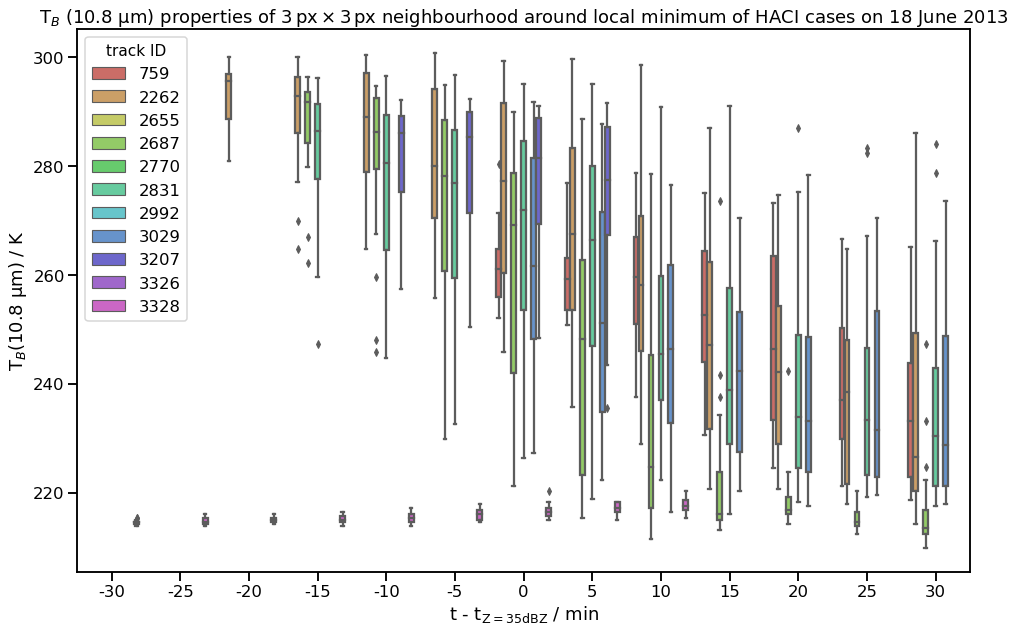

In [102]:
sns.set_context("talk")
fig,ax = plt.subplots(1,1,figsize=(16,10))
plt.gca()
sns.boxplot(x='tidx',y='value',data=ellipsis_values,hue='track ID',
            palette=sns.color_palette("hls", len(track_ids)))
ax.set_ylabel(r"T$_B$(10.8 µm) / K")
ax.set_xlabel(r"t - t$_{\mathrm{Z} = 35 \mathrm{dBZ}}$ / min")
ax.set_title(r"T$_B$ (10.8 µm) properties of $3\,\mathrm{px} \times 3\,\mathrm{px}$ neighbourhood around local minimum of HACI cases on 18 June 2013")
plt.savefig("{}/proj/2020_03_konzept/plots/ir108_locmin_neighbourhood_haci_20130618.pdf".format(local_home_path),
            bbox_inches="tight")

Die Werte in der Nachbarschaft um das lokale Minimum sind für diese eigentlich idealen Fälle schon sehr unterschiedlich. Ein Fall fällt vollständig aus dem Rahmen und folgt nicht dem erwartbaren Lebenszyklusverlauf. Dieser Fall gehört wahrscheinlich nicht in die Klasse isolierte Konvektion aus der Satellitenperspektive

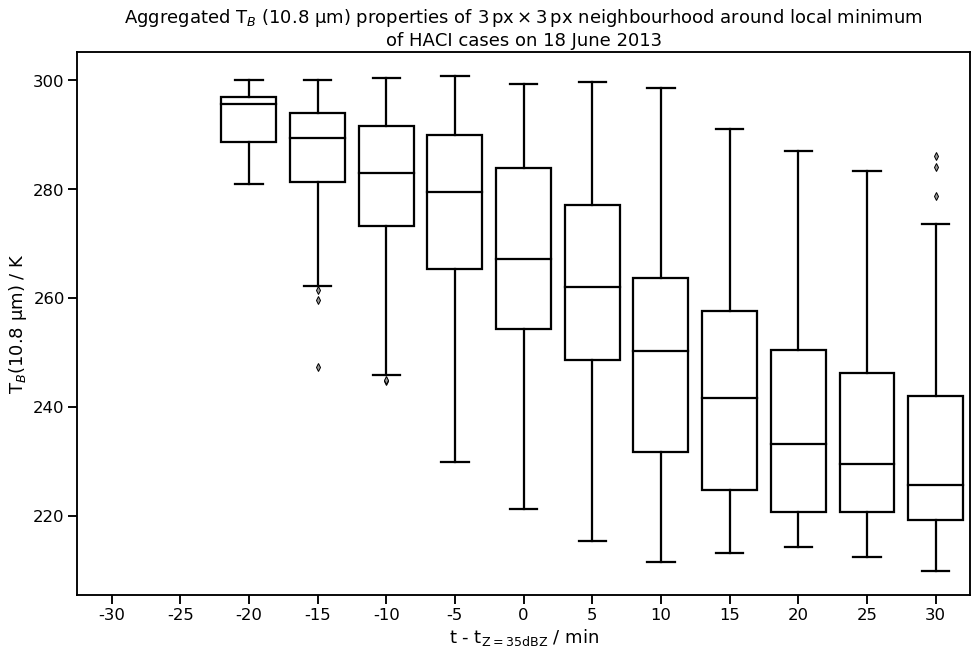

In [118]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
plt.gca()
sns.boxplot(x='tidx',y='value',data=ellipsis_values[ellipsis_values['track ID']!=3328],
            color='white',flierprops=dict(markeredgecolor='k'))
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
ax.set_ylabel(r"T$_B$(10.8 µm) / K")
ax.set_xlabel(r"t - t$_{\mathrm{Z} = 35 \mathrm{dBZ}}$ / min")
ax.set_title(r"Aggregated T$_B$ (10.8 µm) properties of $3\,\mathrm{px} \times 3\,\mathrm{px}$ neighbourhood around local minimum" "\n" r"of HACI cases on 18 June 2013")
plt.savefig("{}/proj/2020_03_konzept/plots/ir108_locmin_neighbourhood_haci_20130618_combined.pdf".format(local_home_path),
            bbox_inches="tight")

Wenn man diesen Fall weglässt, ergibt sich eine recht schöne mittlere Lebenszykluskurve. Zum Auslösungszeitpunkt liegen die Werte um das lokale Minimum typischerweise zwischen 300&thinsp;K und 230&thinsp;K. 20&thinsp;min vorher bei 300&thinsp;K bis 280&thinsp;K. Das finden eines lokalen Minimums scheitert vorher mit der aktuellen Konfiguration. Damit können wir versuchen hoffentlich sinnvolle Objekte zu definieren.

In [124]:
# import scipy.optimize as opt

In [123]:
# def logistic_function(t,t0,L,k,a):
#     return( (L / (1 + np.exp(-k * (t-t0)))) - a)

In [122]:
# t = np.arange(3,13)

# @widgets.interact(L=(0, 300),t0 = (-12,12,0.1),k=(-10,10,0.1),a=(-300,300))
# def f(L=72,t0=6,k=-1,a=-np.mean(means[3:])):#,d=0):
#     fig,ax = plt.subplots(1,1,figsize=(10,5))
#     plt.plot(t, means[3:],'ro')
#     plt.plot(np.arange(3,13,0.1),logistic_function(np.arange(3,13,0.1),t0,L,k,a),'bo')

In [121]:
# def get_logistic_fit(values):
#     means = []

#     for t in values.tidx.unique():
#         means.append(values[values['tidx']==t]['value'].mean())
     
#     nan_loc = np.isnan(means)
    
#     start_tidx = np.min(np.where(nan_loc==False))
#     tidx = np.arange(start_tidx,len(means))
    
#     (t0_,L_,k_,a_), _ = opt.curve_fit(logistic_function,
#                                       tidx,
#                                       means[start_tidx:],
#                                       p0=[6,np.max(means[start_tidx:]),-10,np.mean(means[start_tidx:])])
    
#     return (t0_,L_,k_,a_)

In [120]:
# fits = {tid:{'L':[],'t0':[],'k':[],'a':[]} for tid in track_ids}

# for tid in ellipsis_values['tid'].unique():
#     try:
#         (L,t0,k,a) =  get_logistic_fit(ellipsis_values[ellipsis_values['tid']==tid])
#         fits[tid]['L'] = L
#         fits[tid]['t0'] = t0
#         fits[tid]['k'] = k
#         fits[tid]['a'] = a
#     except Exception as e:
#         print("FEHLER {} bei Track {}.".format(e,tid))
#         continue

In [119]:
# fits

### Wolkenobjekte mit einem Schwellwert

In [ ]:
plt.pcolormesh(rlon,rlat,go.remap_grid(hrv[-1],hlon,hlat,rlon,rlat,3),vmin=0,vmax=1,cmap='gray')
plt.contour(rlon,rlat,np.ma.masked_less(z[-1],5),vmin=5,vmax=70,cmap=rc())

## 3.5 Wolkenmaskenobjekte

Wenn man nur die vollständig bewölkten Pixel betrachtet, könnte man eventuell für dieses Beispiel eine recht gute Trennung von Objekten und Hintergrund bekommen.

In [233]:
cma_object_masks = {tid:{tidx: {'mask':[],
                                'n_objects':[],
                                'object_sizes':[],
                                'centroid_distances':[]} for tidx in np.arange(0,13)} for tid in track_data.keys()}

for tid in track_data:
    for i,c in enumerate(track_data[tid]['cma']):
        try:
            om = ~np.ma.masked_less(track_data[tid]['cma'][i],2).mask*1
            om_l,n_obj = ndi.label(om)
            cma_object_masks[tid][i]['mask'] = om_l
            cma_object_masks[tid][i]['n_objects'] = n_obj

            obj_sizes = []
            for j in np.arange(1,n_obj):
                obj_sizes.append(np.where(om_l==j)[0].size)            

            cma_object_masks[tid][i]['object_sizes'] = obj_sizes

            if n_obj > 1 :
                centroids = ndi.center_of_mass(om,om_l,np.arange(1,n_obj))

                d = []
                for c in centroids:
                    d.append(np.sqrt((c[0] - 25)**2 + (c[0] - 25)**2))

                cma_object_masks[tid][i]['centroid_distances'] = d   
            else:
                centroids = ndi.center_of_mass(om,om_l)
                cma_object_masks[tid][i]['centroid_distances'] = np.sqrt((centroids[0] - 25)**2 + (centroids[0] - 25)**2)
        except:
            for k in cma_object_masks[tid][i].keys():
                cma_object_masks[tid][i][k] = np.nan

In [225]:
centroids

[(28.36964448495898, 26.326344576116682)]

In [234]:
cma_object_masks[2687][6]

{'mask': array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0, 26, 26],
        [ 0,  0,  0, ...,  0, 26, 26],
        [ 0,  0,  0, ...,  0,  0, 26]], dtype=int32),
 'n_objects': 28,
 'object_sizes': [55,
  1,
  8,
  4,
  1,
  4,
  1,
  1,
  1,
  14,
  173,
  2,
  2,
  2,
  1,
  65,
  2,
  5,
  43,
  1,
  2,
  1,
  4,
  1,
  17,
  11,
  1],
 'centroid_distances': [31.858374614186634,
  25.45584412271571,
  22.627416997969522,
  21.213203435596427,
  21.213203435596427,
  18.031222920256962,
  16.97056274847714,
  15.556349186104045,
  11.313708498984761,
  8.182235610872906,
  3.6622409014054695,
  4.242640687119285,
  4.242640687119285,
  6.363961030678928,
  11.313708498984761,
  23.301888081562847,
  17.67766952966369,
  19.79898987322333,
  24.798070372774735,
  21.213203435596427,
  23.33452377915607,
  24.041630560342615,
  26.16295090390226,
  28.284271247461902,
  30.8631312

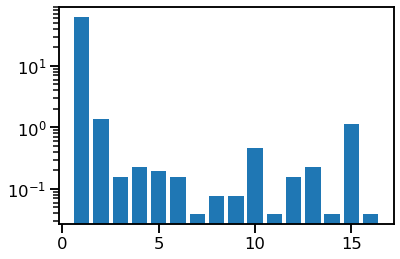

In [252]:
plt.bar(np.arange(1,cma_object_masks[759][6]['n_objects']),
        (np.array(cma_object_masks[759][6]['object_sizes']) / (51**2))*100)
plt.yscale("log")

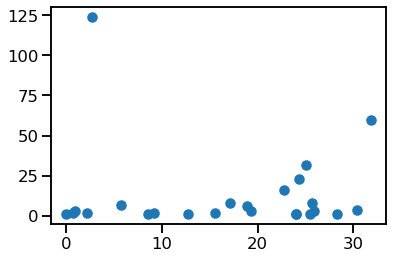

In [244]:
plt.scatter(cma_object_masks[2687][0]['centroid_distances'],
            cma_object_masks[2687][0]['object_sizes'])

In [170]:
centroids = ndi.center_of_mass(om[6],om_l[6],np.arange(1,n_obj))

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/scipy/ndimage/measurements.py:1359: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


In [172]:
centroids[0]

(14.656458055925432, 27.672436750998667)

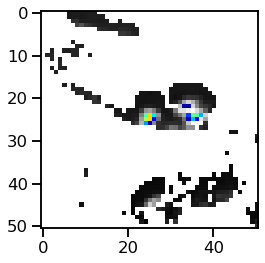

In [134]:
plt.imshow(np.ma.masked_where(cma_object_masks[2687][6]==1,track_data[2687]['ir108'][6]),vmin=210,vmax=300,cmap=emap)

Dieser Beispielfall ist ein relativ gut isolierter Fall und trotzdem ist es bereits hier nicht einfach die Objekte richtig zu trennen.